<a href="https://colab.research.google.com/github/shivam9ronaldo7/ml-specialization-andrew-ng/blob/main/week2/C1_W2_Lab03_Feature_Scaling_and_Learning_Rate_Soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Collab Specific Changes

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
    print("Running in Google Colab")
    !git clone https://github.com/shivam9ronaldo7/ml-specialization-andrew-ng.git
    pwd = !pwd
    print("Pwd: {}".format(pwd))
    %cd ml-specialization-andrew-ng/week2/
    pwd = !pwd
    print("Pwd: {}".format(pwd))
else:
   print("Not in Google Colab")

Running in Google Colab
Cloning into 'ml-specialization-andrew-ng'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 117 (delta 43), reused 61 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (117/117), 5.10 MiB | 20.39 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Pwd: ['/content']
/content/ml-specialization-andrew-ng/week2
Pwd: ['/content/ml-specialization-andrew-ng/week2']


# Optional Lab: Feature scaling and Learning Rate (Multi-variable)

## Goals
In this lab you will:
- Utilize  the multiple variables routines developed in the previous lab
- run Gradient Descent on a data set with multiple features
- explore the impact of the *learning rate alpha* on gradient descent
- improve performance of gradient descent by *feature scaling* using z-score normalization

## Tools
You will utilize the functions developed in the last lab as well as matplotlib and NumPy.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lab_utils_multi import  load_house_data, run_gradient_descent
from lab_utils_multi import  norm_plot, plt_equal_scale, plot_cost_i_w
from lab_utils_common import dlc
np.set_printoptions(precision=2)
plt.style.use('./deeplearning.mplstyle')

## Notation

|General <br />  Notation  | Description| Python (if applicable) |
|: ------------|: ------------------------------------------------------------||
| $a$ | scalar, non bold                                                      ||
| $\mathbf{a}$ | vector, bold                                                 ||
| $\mathbf{A}$ | matrix, bold capital                                         ||
| **Regression** |         |    |     |
|  $\mathbf{X}$ | training example maxtrix                  | `X_train` |   
|  $\mathbf{y}$  | training example  targets                | `y_train`
|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{th}$Training Example | `X[i]`, `y[i]`|
| m | number of training examples | `m`|
| n | number of features in each example | `n`|
|  $\mathbf{w}$  |  parameter: weight,                       | `w`    |
|  $b$           |  parameter: bias                                           | `b`    |     
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | The result of the model evaluation at  $\mathbf{x}^{(i)}$ parameterized by $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` |
|$\frac{\partial J(\mathbf{w},b)}{\partial w_j}$| the gradient or partial derivative of cost with respect to a parameter $w_j$ |`dj_dw[j]`|
|$\frac{\partial J(\mathbf{w},b)}{\partial b}$| the gradient or partial derivative of cost with respect to a parameter $b$| `dj_db`|

#  Problem Statement

As in the previous labs, you will use the motivating example of housing price prediction. The training data set contains many examples with 4 features (size, bedrooms, floors and age) shown in the table below. Note, in this lab, the Size feature is in sqft while earlier labs utilized 1000 sqft.  This data set is larger than the previous lab.

We would like to build a linear regression model using these values so we can then predict the price for other houses - say, a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old.

##  Dataset:
| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|----------------------- |  
| 952             | 2                   | 1                | 65           | 271.5                  |  
| 1244            | 3                   | 2                | 64           | 232                    |  
| 1947            | 3                   | 2                | 17           | 509.8                  |  
| ...             | ...                 | ...              | ...          | ...                    |


In [3]:
# load the dataset
X_train, y_train = load_house_data()
X_features = ['size(sqft)','bedrooms','floors','age']

Let's view the dataset and its features by plotting each feature versus price.

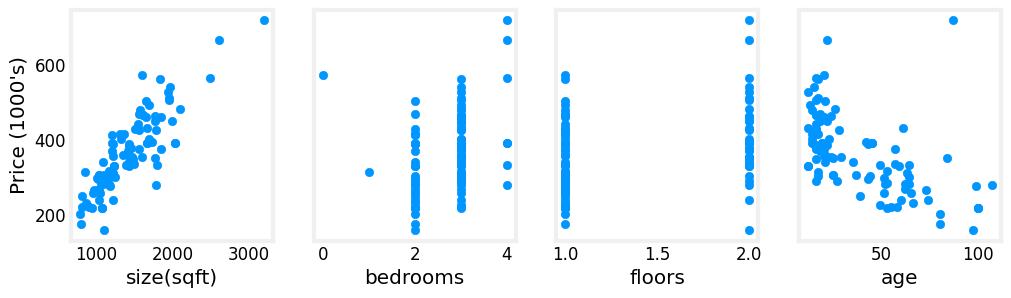

In [4]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

Plotting each feature vs. the target, price, provides some indication of which features have the strongest influence on price. Above, increasing size also increases price. Bedrooms and floors don't seem to have a strong impact on price. Newer houses have higher prices than older houses.

<a name="toc_15456_5"></a>
## Gradient Descent With Multiple Variables
Here are the equations you developed in the last lab on gradient descent for multiple variables.:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j = 0..n-1}\newline
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


## Learning Rate
<figure>
    <img src="https://github.com/shivam9ronaldo7/ml-specialization-andrew-ng/blob/main/week2/images/C1_W2_Lab06_learningrate.PNG?raw=1" style="width:1200px;" >
</figure>
The lectures discussed some of the issues related to setting the learning rate $\alpha$. The learning rate controls the size of the update to the parameters. See equation (1) above. It is shared by all the parameters.  

Let's run gradient descent and try a few settings of $\alpha$ on our data set

### $\alpha$ = 9.9e-7

In [5]:
#set alpha to 9.9e-7
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha = 9.9e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 9.55884e+04  5.5e-01  1.0e-03  5.1e-04  1.2e-02  3.6e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 1.28213e+05 -8.8e-02 -1.7e-04 -1.0e-04 -3.4e-03 -4.8e-05  6.4e+05  1.2e+03  6.2e+02  1.6e+04  4.1e+02
        2 1.72159e+05  6.5e-01  1.2e-03  5.9e-04  1.3e-02  4.3e-04 -7.4e+05 -1.4e+03 -7.0e+02 -1.7e+04 -4.9e+02
        3 2.31358e+05 -2.1e-01 -4.0e-04 -2.3e-04 -7.5e-03 -1.2e-04  8.6e+05  1.6e+03  8.3e+02  2.1e+04  5.6e+02
        4 3.11100e+05  7.9e-01  1.4e-03  7.1e-04  1.5e-02  5.3e-04 -1.0e+06 -1.8e+03 -9.5e+02 -2.3e+04 -6.6e+02
        5 4.18517e+05 -3.7e-01 -7.1e-04 -4.0e-04 -1.3e-02 -2.1e-04  1.2e+06  2.1e+03  1.1e+03  2.8e+04  7.5e+02
        6 5.63212e+05  9.7e-01  1.7e-03  8.7e-04  1.8e-02  6.6e-04 -1.3e+06 -2.5e+03 -1.3e+03 -3.1e+04 -

It appears the learning rate is too high.  The solution does not converge. Cost is *increasing* rather than decreasing. Let's plot the result:

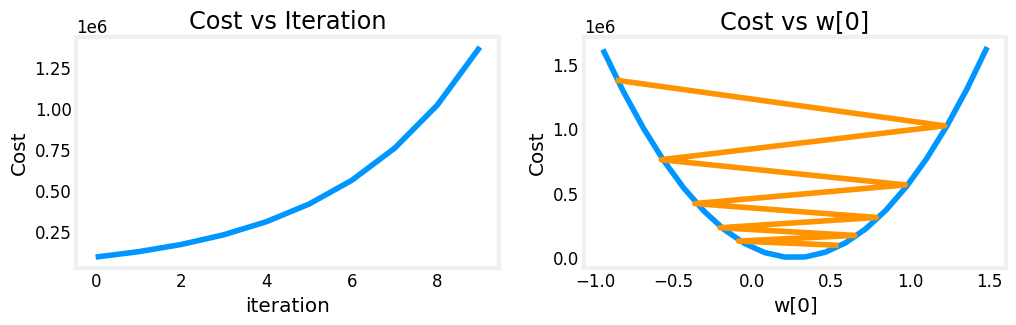

In [6]:
plot_cost_i_w(X_train, y_train, hist)

The plot on the right shows the value of one of the parameters, $w_0$. At each iteration, it is overshooting the optimal value and as a result, cost ends up *increasing* rather than approaching the minimum. Note that this is not a completely accurate picture as there are 4 parameters being modified each pass rather than just one. This plot is only showing $w_0$ with the other parameters fixed at benign values. In this and later plots you may notice the blue and orange lines being slightly off.


### $\alpha$ = 9e-7
Let's try a bit smaller value and see what happens.

In [7]:
#set alpha to 9e-7
_,_,hist = run_gradient_descent(X_train, y_train, 10, alpha = 9e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 6.64616e+04  5.0e-01  9.1e-04  4.7e-04  1.1e-02  3.3e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 6.18990e+04  1.8e-02  2.1e-05  2.0e-06 -7.9e-04  1.9e-05  5.3e+05  9.8e+02  5.2e+02  1.3e+04  3.4e+02
        2 5.76572e+04  4.8e-01  8.6e-04  4.4e-04  9.5e-03  3.2e-04 -5.1e+05 -9.3e+02 -4.8e+02 -1.1e+04 -3.4e+02
        3 5.37137e+04  3.4e-02  3.9e-05  2.8e-06 -1.6e-03  3.8e-05  4.9e+05  9.1e+02  4.8e+02  1.2e+04  3.2e+02
        4 5.00474e+04  4.6e-01  8.2e-04  4.1e-04  8.0e-03  3.2e-04 -4.8e+05 -8.7e+02 -4.5e+02 -1.1e+04 -3.1e+02
        5 4.66388e+04  5.0e-02  5.6e-05  2.5e-06 -2.4e-03  5.6e-05  4.6e+05  8.5e+02  4.5e+02  1.2e+04  2.9e+02
        6 4.34700e+04  4.5e-01  7.8e-04  3.8e-04  6.4e-03  3.2e-04 -4.4e+05 -8.1e+02 -4.2e+02 -9.8e+03 -

Cost is decreasing throughout the run showing that alpha is not too large.

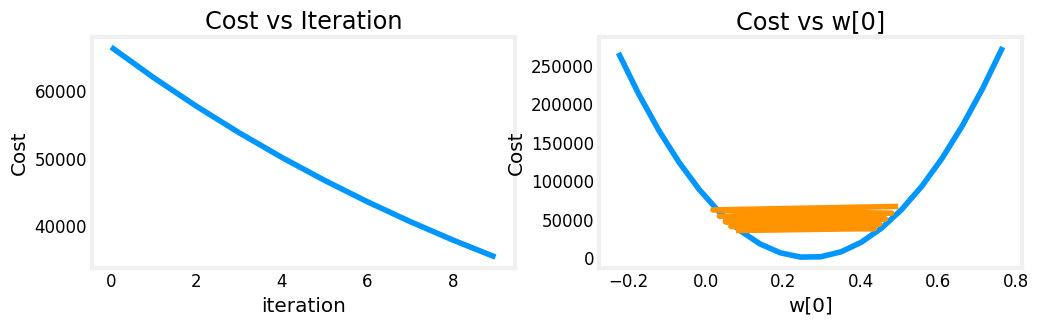

In [8]:
plot_cost_i_w(X_train, y_train, hist)

On the left, you see that cost is decreasing as it should. On the right, you can see that $w_0$ is still oscillating around the minimum, but the cost is decreasing with every iteration rather than increasing. Note above that `dj_dw[0]` changes sign with each iteration as `w[0]` jumps over the optimal value.
This alpha value will converge. You can vary the number of iterations to see how it behaves.

### $\alpha$ = 1e-7
Let's try a bit smaller value for $\alpha$ and see what happens.

In [9]:
#set alpha to 1e-7
_,_,hist = run_gradient_descent(X_train, y_train, 10, alpha = 1e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 4.42313e+04  5.5e-02  1.0e-04  5.2e-05  1.2e-03  3.6e-05 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 2.76461e+04  9.8e-02  1.8e-04  9.2e-05  2.2e-03  6.5e-05 -4.3e+05 -7.9e+02 -4.0e+02 -9.5e+03 -2.8e+02
        2 1.75102e+04  1.3e-01  2.4e-04  1.2e-04  2.9e-03  8.7e-05 -3.4e+05 -6.1e+02 -3.1e+02 -7.3e+03 -2.2e+02
        3 1.13157e+04  1.6e-01  2.9e-04  1.5e-04  3.5e-03  1.0e-04 -2.6e+05 -4.8e+02 -2.4e+02 -5.6e+03 -1.8e+02
        4 7.53002e+03  1.8e-01  3.3e-04  1.7e-04  3.9e-03  1.2e-04 -2.1e+05 -3.7e+02 -1.9e+02 -4.2e+03 -1.4e+02
        5 5.21639e+03  2.0e-01  3.5e-04  1.8e-04  4.2e-03  1.3e-04 -1.6e+05 -2.9e+02 -1.5e+02 -3.1e+03 -1.1e+02
        6 3.80242e+03  2.1e-01  3.8e-04  1.9e-04  4.5e-03  1.4e-04 -1.3e+05 -2.2e+02 -1.1e+02 -2.3e+03 -

Cost is decreasing throughout the run showing that $\alpha$ is not too large.

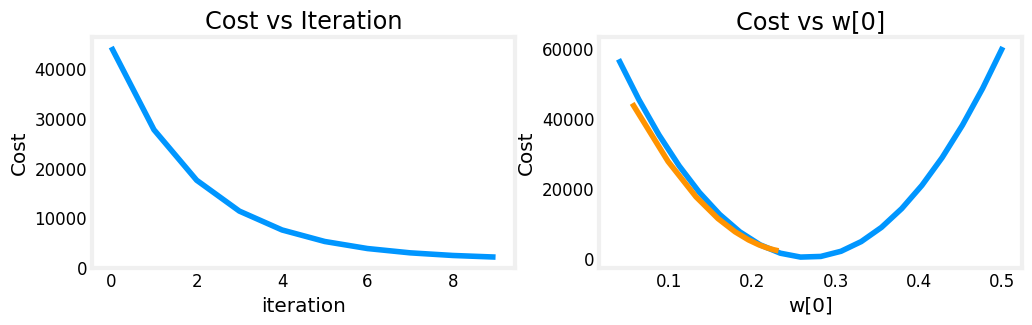

In [10]:
plot_cost_i_w(X_train,y_train,hist)

On the left, you see that cost is decreasing as it should. On the right, you can see that $w_0$ is approaching the minimum without oscillations. `dj_w0` is negative throughout the run. This solution will also converge.

## Feature Scaling
<figure>
    <img src="https://github.com/shivam9ronaldo7/ml-specialization-andrew-ng/blob/main/week2/images/C1_W2_Lab06_featurescalingheader.PNG?raw=1" style="width:1200px;" >
</figure>
The lectures described the importance of rescaling the dataset so the features have a similar range.
If you are interested in the details of why this is the case, click on the 'details' header below. If not, the section below will walk through an implementation of how to do feature scaling.

<details>
<summary>
    <font size='3', color='darkgreen'><b>Details</b></font>
</summary>

Let's look again at the situation with $\alpha$ = 9e-7. This is pretty close to the maximum value we can set $\alpha$  to without diverging. This is a short run showing the first few iterations:

<figure>
    <img src="https://github.com/shivam9ronaldo7/ml-specialization-andrew-ng/blob/main/week2/images/C1_W2_Lab06_ShortRun.PNG?raw=1" style="width:1200px;" >
</figure>

Above, while cost is being decreased, its clear that $w_0$ is making more rapid progress than the other parameters due to its much larger gradient.

The graphic below shows the result of a very long run with $\alpha$ = 9e-7. This takes several hours.

<figure>
    <img src="https://github.com/shivam9ronaldo7/ml-specialization-andrew-ng/blob/main/week2/images/C1_W2_Lab06_LongRun.PNG?raw=1" style="width:1200px;" >
</figure>
    
Above, you can see cost decreased slowly after its initial reduction. Notice the difference between `w0` and `w1`,`w2`,`w3` as well as  `dj_dw0` and `dj_dw1-3`. `w0` reaches its near final value very quickly and `dj_dw0` has quickly decreased to a small value showing that `w0` is near the final value. The other parameters were reduced much more slowly.

Why is this?  Is there something we can improve? See below:
<figure>
    <center> <img src="https://github.com/shivam9ronaldo7/ml-specialization-andrew-ng/blob/main/week2/images/C1_W2_Lab06_scale.PNG?raw=1"   ></center>
</figure>   

The figure above shows why $w$'s are updated unevenly.
- $\alpha$ is shared by all parameter updates ($w$'s and $b$).
- the common error term is multiplied by the features for the $w$'s. (not $b$).
- the features vary significantly in magnitude making some features update much faster than others. In this case, $w_0$ is multiplied by 'size(sqft)', which is generally > 1000,  while $w_1$ is multiplied by 'number of bedrooms', which is generally 2-4.
    
The solution is Feature Scaling.

The lectures discussed three different techniques:
- Feature scaling, essentially dividing each positive feature by its maximum value, or more generally, rescale each feature by both its minimum and maximum values using (x-min)/(max-min). Both ways normalizes features to the range of -1 and 1, where the former method works for positive features which is simple and serves well for the lecture's example, and the latter method works for any features.
- Mean normalization: $x_i := \dfrac{x_i - \mu_i}{max - min} $
- Z-score normalization which we will explore below.


### z-score normalization
After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

To implement z-score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$
where $j$ selects a feature or a column in the $\mathbf{X}$ matrix. $µ_j$ is the mean of all the values for feature (j) and $\sigma_j$ is the standard deviation of feature (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$

>**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (living room area and number of bed-
rooms), we must first normalize x using the mean and standard deviation
that we had previously computed from the training set.

**Implementation**

In [11]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray (m,n))     : input data, m examples, n features

    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma

    return (X_norm, mu, sigma)

#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

Let's look at the steps involved in Z-score normalization. The plot below shows the transformation step by step.

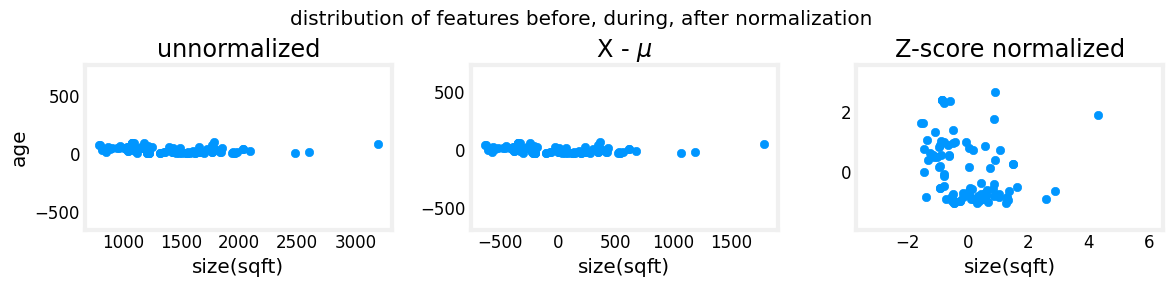

In [12]:
mu     = np.mean(X_train,axis=0)
sigma  = np.std(X_train,axis=0)
X_mean = (X_train - mu)
X_norm = (X_train - mu)/sigma

fig,ax=plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X_train[:,0], X_train[:,3])
ax[0].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[0].set_title("unnormalized")
ax[0].axis('equal')

ax[1].scatter(X_mean[:,0], X_mean[:,3])
ax[1].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')

ax[2].scatter(X_norm[:,0], X_norm[:,3])
ax[2].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[2].set_title(r"Z-score normalized")
ax[2].axis('equal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("distribution of features before, during, after normalization")
plt.show()

The plot above shows the relationship between two of the training set parameters, "age" and "size(sqft)". *These are plotted with equal scale*.
- Left: Unnormalized: The range of values or the variance of the 'size(sqft)' feature is much larger than that of age
- Middle: The first step removes the mean or average value from each feature. This leaves features that are centered around zero. It's difficult to see the difference for the 'age' feature, but 'size(sqft)' is clearly around zero.
- Right: The second step divides by the standard deviation. This leaves both features centered at zero with a similar scale.

Let's normalize the data and compare it to the original data.

In [13]:
# normalize the original features
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

X_mu = [1.42e+03 2.72e+00 1.38e+00 3.84e+01], 
X_sigma = [411.62   0.65   0.49  25.78]
Peak to Peak range by column in Raw        X:[2.41e+03 4.00e+00 1.00e+00 9.50e+01]
Peak to Peak range by column in Normalized X:[5.85 6.14 2.06 3.69]


The peak to peak range of each column is reduced from a factor of thousands to a factor of 2-3 by normalization.

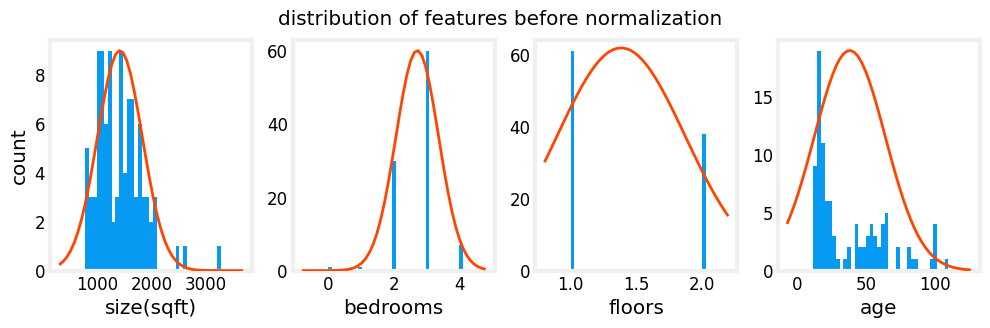

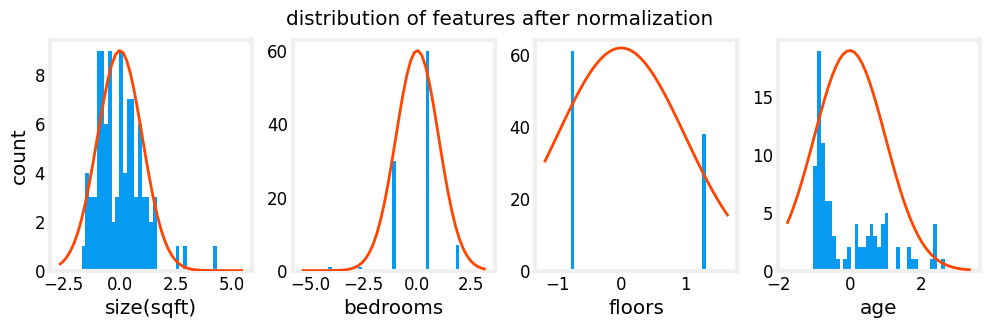

In [14]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    norm_plot(ax[i],X_train[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count");
fig.suptitle("distribution of features before normalization")
plt.show()
fig,ax=plt.subplots(1,4,figsize=(12,3))
for i in range(len(ax)):
    norm_plot(ax[i],X_norm[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count");
fig.suptitle("distribution of features after normalization")

plt.show()

Notice, above, the range of the normalized data (x-axis) is centered around zero and roughly +/- 2. Most importantly, the range is similar for each feature.

Let's re-run our gradient descent algorithm with normalized data.
Note the **vastly larger value of alpha**. This will speed up gradient descent.

In [15]:
w_norm, b_norm, hist = run_gradient_descent(X_norm, y_train, 1000, 1.0e-1, )

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 5.76170e+04  8.9e+00  3.0e+00  3.3e+00 -6.0e+00  3.6e+01 -8.9e+01 -3.0e+01 -3.3e+01  6.0e+01 -3.6e+02
      100 2.21086e+02  1.1e+02 -2.0e+01 -3.1e+01 -3.8e+01  3.6e+02 -9.2e-01  4.5e-01  5.3e-01 -1.7e-01 -9.6e-03
      200 2.19209e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.0e-02  1.5e-02  1.7e-02 -6.0e-03 -2.6e-07
      300 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.0e-03  5.1e-04  5.7e-04 -2.0e-04 -6.9e-12
      400 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.4e-05  1.7e-05  1.9e-05 -6.6e-06 -2.7e-13
      500 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.1e-06  5.6e-07  6.2e-07 -2.2e-07 -2.6e-13
      600 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.7e-08  1.9e-08  2.1e-08 -7.3e-09 -

The scaled features get very accurate results **much, much faster!**. Notice the gradient of each parameter is tiny by the end of this fairly short run. A learning rate of 0.1 is a good start for regression with normalized features.
Let's plot our predictions versus the target values. Note, the prediction is made using the normalized feature while the plot is shown using the original feature values.

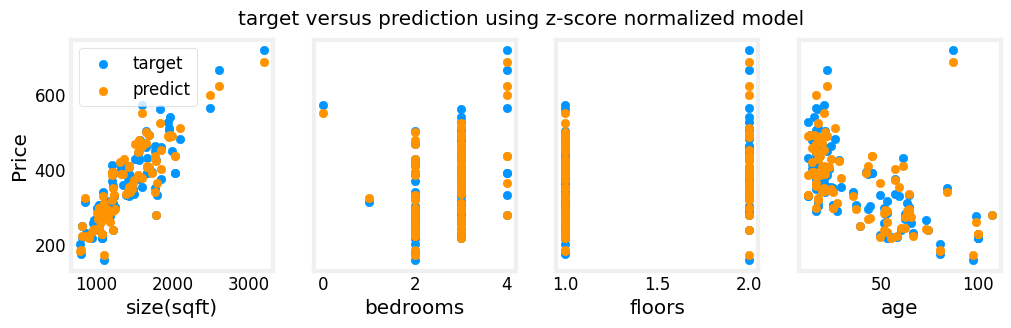

In [16]:
#predict target using normalized features
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

    # plot predictions and targets versus original features
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],yp,color=dlc["dlorange"], label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

The results look good. A few points to note:
- with multiple features, we can no longer have a single plot showing results versus features.
- when generating the plot, the normalized features were used. Any predictions using the parameters learned from a normalized training set must also be normalized.

**Prediction**
The point of generating our model is to use it to predict housing prices that are not in the data set. Let's predict the price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old. Recall, that you must normalize the data with the mean and standard deviation derived when the training data was normalized.

In [17]:
# First, normalize out example.
x_house = np.array([1200, 3, 1, 40])
x_house_norm = (x_house - X_mu) / X_sigma
print(x_house_norm)
x_house_predict = np.dot(x_house_norm, w_norm) + b_norm
print(f" predicted price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old = ${x_house_predict*1000:0.0f}")

[-0.53  0.43 -0.79  0.06]
 predicted price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old = $318709


**Cost Contours**  
<img align="left" src="https://github.com/shivam9ronaldo7/ml-specialization-andrew-ng/blob/main/week2/images/C1_W2_Lab06_contours.PNG?raw=1"   style="width:240px;" >Another way to view feature scaling is in terms of the cost contours. When feature scales do not match, the plot of cost versus parameters in a contour plot is asymmetric.

In the plot below, the scale of the parameters is matched. The left plot is the cost contour plot of w[0], the square feet versus w[1], the number of bedrooms before normalizing the features. The plot is so asymmetric, the curves completing the contours are not visible. In contrast, when the features are normalized, the cost contour is much more symmetric. The result is that updates to parameters during gradient descent can make equal progress for each parameter.


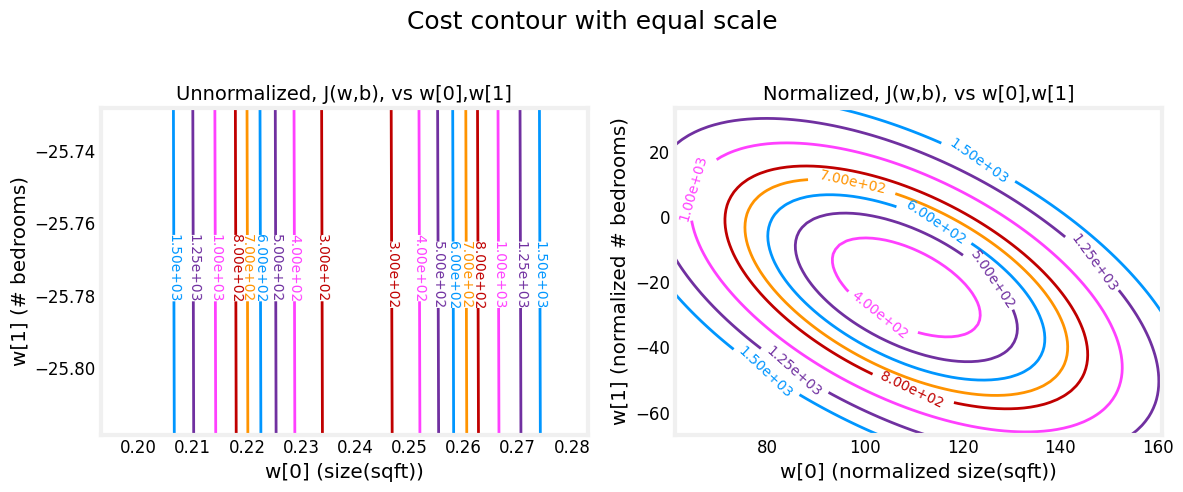

In [18]:
plt_equal_scale(X_train, X_norm, y_train)


## Congratulations!
In this lab you:
- utilized the routines for linear regression with multiple features you developed in previous labs
- explored the impact of the learning rate  $\alpha$ on convergence
- discovered the value of feature scaling using z-score normalization in speeding convergence

## Acknowledgments
The housing data was derived from the [Ames Housing dataset](http://jse.amstat.org/v19n3/decock.pdf) compiled by Dean De Cock for use in data science education.